# Stanford Stats 191

## Introduction

This is a re-creation of the Stanford Stats 191 course, using Python eco-system tools, instead of R. This is lecture "Multiple linear regression" ( see https://web.stanford.edu/class/stats191/notebooks/Multiple_linear_regression.html 
)




## Initial Notebook Setup

```watermark``` documents the Python and package environment, ```black``` is my chosen Python formatter

In [160]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [161]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [162]:
%matplotlib inline

All imports go here.

In [163]:
import pandas as pd
import numpy as np
import seaborn as sn

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm

from statsmodels.sandbox.regression.predstd import (
    wls_prediction_std,
)

from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_goldfeldquandt

from statsmodels.stats.anova import anova_lm


import os

-----
## Read and Explore Data

Read a medical dataset relating to prostate cancer

Data details are:


|Variable|Description|
|:--|--|
|lcavol|(log) Cancer Volume|
|lweight|	(log) Weight|
|age|	Patient age|
|lbph|	(log) Vening Prostatic Hyperplasia|
|svi	|Seminal Vesicle Invasion|
|lcp	|(log) Capsular Penetration|
|gleason|	Gleason score|
|pgg45	|Percent of Gleason score 4 or 5|
|lpsa	|(log) Prostate Specific Antigen|
|train	|Label for test / training split|



In [164]:
data = pd.read_csv('../data/prostate.txt', sep='\t')

In [165]:
data.head()

,Unnamed: 0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


### Display Data

We use pandas to give use a quick snapshot of all the variables.  We could have removed the "Unnamed" column, but this is just initial exploration.  If we look at the ```lpsa``` row or column, we see that there is apparently linear correlation with some of the other variables.


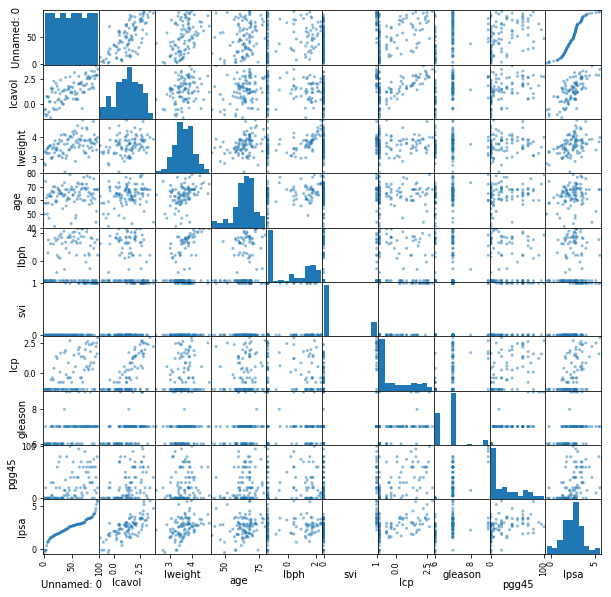

In [166]:
_ = pd.plotting.scatter_matrix(data, figsize=(10, 10))

----
## Fit Model

The model is of the form of the equation below (linear in all parameters of interest, with Gaussian noise added). Under the Null Hypothesis (H0), all the beta-s are zero.



$$Y_i = \beta_0 + \beta_1 X_{i1} + \dots + \beta_p X_{ip} + \varepsilon_i$$

In [167]:
res = ols(
    ' lpsa ~ lcavol + lweight + age + lbph + svi + lcp  + pgg45',
    data=data,
).fit()

We list the model parameter values (the betas), and the probability of seeing each value under H0

In [168]:
print(
    f'{"Parameter":30} {"Value":>12}   {"Probability (under H0)"}'
)
_ = [
    print(f'{na:30} {pa:12.5f}   {pr:.5g}')
    for na, pa, pr in zip(
        res.params.index, res.params.values, res.pvalues
    )
]

Parameter                             Value   Probability (under H0)
Intercept                           0.49415   0.57304
lcavol                              0.56955   2.4614e-09
lweight                             0.61442   0.0026221
age                                -0.02091   0.059999
lbph                                0.09735   0.094411
svi                                 0.75240   0.0021633
lcp                                -0.10496   0.24323
pgg45                               0.00532   0.11923


We sort them by probability

In [169]:
p_srtd = pd.DataFrame()
p_srtd['parameter'] = res.params.index
p_srtd['value'] = res.params.values
p_srtd['probsh0'] = res.pvalues.values
temp = p_srtd.sort_values(by='probsh0')
temp

,parameter,value,probsh0
1,lcavol,0.569546,2.461449e-09
5,svi,0.752397,2.163265e-03
2,lweight,0.614420,2.622121e-03
3,age,-0.020913,5.999883e-02
4,lbph,0.097353,9.441057e-02
7,pgg45,0.005324,1.192260e-01
6,lcp,-0.104959,2.432323e-01
0,Intercept,0.494155,5.730382e-01


The estimate of the error signal must take into account the number of parameters we have used in the model.  More parameters will make the estimate larger for a given Sum Of Squared Errors (SSE).  We show how the RegressionResults attribute ```df_resid``` is calculated

In [170]:
print(f'{res.df_resid} =  {len(data)} - {res.df_model} - 1')

89.0 =  97 - 7.0 - 1


$$\widehat{\sigma}^2 = \frac{SSE}{n-p-1} \sim \sigma^2 \cdot \frac{\chi^2_{n-p-1}}{n-p\
-1}$$

Compute our estimate of the standard deviation of the error noise.

In [171]:
sigma_hat = np.sqrt(
    sum(res.resid * res.resid) / res.df_resid
)
sigma_hat

0.6959558777863034

We can check this against the value in the RegressionResults object

In [172]:
np.sqrt(res.mse_resid)

0.6959558777863034

### Display Summary of Regression Results

We display the results of the regression by OLS, for two different values of ```alpha``` (that sets the probability bounds for which we want confidence intervals).  The default value for ```statsmodels``` is 0.05.  The lecture series we are following has ```alpha``` at 0.1

#### Statsmodels default

In [173]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     25.01
Date:                Sat, 21 Mar 2020   Prob (F-statistic):           1.54e-18
Time:                        22:06:30   Log-Likelihood:                -98.303
No. Observations:                  97   AIC:                             212.6
Df Residuals:                      89   BIC:                             233.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4942      0.874      0.566      0.573      -1.242       2.230
lcavol         0.5695      0.086      6.634      0.000       0.399       0.740
lweight        0.6144      0.198      3.096      0.003       0.220       1.009
age           -0.0209      0.011     -1.905      0.060      -0.043       0.001
lbph           0.0974      0.058      1.691      0.094      -0.017       0.212
svi            0.7524      0.238      3.159      0.002       0.279       1.226
lcp           -0.1050      0.089     -1.175      0.243      -0.282       0.073
pgg45          0.0053      0.003      1.573      0.119      -0.001       0.012
==============================================================================
Omnibus:                        0.550   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.759   Jarque-Bera (JB):                0.175
Skew:                           0.018   Prob(JB):                        0.916
Kurtosis:                       3.205   Cond. No.                         875.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Lecture series default for ```alpha``` 

```alpha``` is the probability used to determine confidence intervals of parameter estimates

In [174]:
res.summary(alpha=0.1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     25.01
Date:                Sat, 21 Mar 2020   Prob (F-statistic):           1.54e-18
Time:                        22:06:30   Log-Likelihood:                -98.303
No. Observations:                  97   AIC:                             212.6
Df Residuals:                      89   BIC:                             233.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|       [0.05       0.95]
------------------------------------------------------------------------------
Intercept      0.4942      0.874      0.566      0.573      -0.958       1.946
lcavol         0.5695      0.086      6.634      0.000       0.427       0.712
lweight        0.6144      0.198      3.096      0.003       0.285       0.944
age           -0.0209      0.011     -1.905      0.060      -0.039      -0.003
lbph           0.0974      0.058      1.691      0.094       0.002       0.193
svi            0.7524      0.238      3.159      0.002       0.357       1.148
lcp           -0.1050      0.089     -1.175      0.243      -0.253       0.044
pgg45          0.0053      0.003      1.573      0.119      -0.000       0.011
==============================================================================
Omnibus:                        0.550   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.759   Jarque-Bera (JB):                0.175
Skew:                           0.018   Prob(JB):                        0.916
Kurtosis:                       3.205   Cond. No.                         875.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---------
We display the confidence intervals at the 90% level for the parameters we have estimated

In [175]:
res.conf_int(alpha=0.1)

,0,1
Intercept,-0.957849,1.946158
lcavol,0.426855,0.712237
lweight,0.284566,0.944274
age,-0.039160,-0.002667
lbph,0.001639,0.193066
svi,0.356505,1.148289
lcp,-0.253468,0.043549
pgg45,-0.000301,0.010950


----
### Explicit Check of Parameter Values

We can check (and better understand the summary) by explicitly computing the parameter estimates

$${\hat {\beta }}=(X^{T}X)^{-1}X^{T}y.$$


We convert ```pandas``` data structures into ```numpy``` data structures, to use the linear algebra functions of ```numpy```.  We have to add a column of ones, to get the intercept

In [176]:
data['ones'] = np.ones(len(data))
X = data[
    [
        'ones',
        'lcavol',
        'lweight',
        'age',
        'lbph',
        'svi',
        'lcp',
        'pgg45',
    ]
]
y = data['lpsa'].to_numpy()

X.to_numpy()

beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y.T

If we compare the OLS values with the explicit values, we see they match

In [177]:
print(f'{"Linear Alg Value":>20}  {"OLS Value":>20}')
_ = [
    print(f'{p1:20.5f}, {p2:20.5f}')
    for p1, p2 in zip(beta_hat, res.params.values)
]

    Linear Alg Value             OLS Value
             0.49415,              0.49415
             0.56955,              0.56955
             0.61442,              0.61442
            -0.02091,             -0.02091
             0.09735,              0.09735
             0.75240,              0.75240
            -0.10496,             -0.10496
             0.00532,              0.00532


----
### Adjusted R^2

We compute the R^2 values explicitly, and show they match values in the RegressionResults object.  Note there seems to be a difference between the abbreviations used in the lectures, and used in the RegressionResults object.  In my code, I will use the STATS191 lecture conventions  (even though I think the ```statsmodels``` conventions make more sense)

$$SST = \sum_{i=1}^n(Y_i - \overline{Y})^2 = SSE + SSR$$

In [178]:
SST = sum(
    (data['lpsa'] - data['lpsa'].mean())
    * (data['lpsa'] - data['lpsa'].mean())
)
print(
    f' Explicit Calculation = {SST:15.5f},\n Statsmodels Value    = {res.centered_tss:15.5f}'
)

 Explicit Calculation =       127.91766,
 Statsmodels Value    =       127.91766


$$SSR = \sum_{i=1}^n(\overline{Y} - \widehat{Y}_i)^2$$

In [179]:
SSR = sum(
    (res.predict() - data['lpsa'].mean())
    * (res.predict() - data['lpsa'].mean())
)
SSR, res.ess
print(
    f' Explicit Calculation = {SSR:15.5f},\n Statsmodels Value    = {res.ess:15.5f}'
)

 Explicit Calculation =        84.81010,
 Statsmodels Value    =        84.81010


$$ SSE = \sum_{i=1}^n(Y_i - \widehat{Y}_i)^2$$

In [180]:
SSE = sum(
    (res.predict() - data['lpsa'])
    * (res.predict() - data['lpsa'])
)
SSE, res.ssr
print(
    f' Explicit Calculation = {SSE:15.5f},\n Statsmodels Value    = {res.ssr:15.5f}'
)

 Explicit Calculation =        43.10756,
 Statsmodels Value    =        43.10756


$$R^2 = \frac{SSR}{SST}$$

In [181]:
r_2 = SSR / SST
r_2, res.rsquared
print(
    f' Explicit Calculation = {r_2:15.5f},\n Statsmodels Value    = {res.rsquared:15.5f}'
)

 Explicit Calculation =         0.66301,
 Statsmodels Value    =         0.66301


If we add more and more explanatory variables, even random ones, R^2 will get smaller.  We adjust for this

$$R^2_a = 1 - \frac{SSE/(n-p-1)}{SST/(n-1)} = 1 - \frac{MSE}{MST}.$$

We compute R2_Adjusted in three different ways; as expected, all three values match

In [182]:
r_adjust_1 = 1 - res.mse_resid / res.mse_total


r_adjust_2 = 1 - (SSE / (len(data) - len(res.params))) / (
    SST / (len(data) - 1)
)

print(
    f' Explicit Calculation = {r_adjust_2:15.5f},\n Explicit Calculation2= {r_adjust_1:15.5f},\n Statsmodels Value    = {res.rsquared_adj:15.5f}'
)

 Explicit Calculation =         0.63650,
 Explicit Calculation2=         0.63650,
 Statsmodels Value    =         0.63650


---
### Goodness of Fit

We form the F statistic by computing the ratio of:
* mean square difference of the predictions from the mean of the dependent variable
  
  to
  
* mean square difference of the predictions from the actual values of the dependent variable

If the Null Hypothesis (H0) holds (no relationship between explanatory and dependent variable), then this should be close to 1.0.  The larger the F statistic is, the more the variation of the dependent variable is explained by the explanatory variables.

When we ran our OLS fit, the F statistic was computed, and returned in the RegressionResults object.  We check its value, and the RegressionResults object is consistent

In [183]:
F = res.mse_model / res.mse_resid

F2 = (SSR / (len(res.params) - 1)) / (
    SSE / (len(data) - len(res.params))
)

print(
    f' Explicit Calculation = {F:15.5f},\n Explicit Calculation2= {F2:15.5f},\n Statsmodels Value    = {res.fvalue:15.5f}'
)

 Explicit Calculation =        25.01417,
 Explicit Calculation2=        25.01417,
 Statsmodels Value    =        25.01417


Compute the degrees of freedom of the numerator and denominator of the F ratio

In [184]:
dfn = len(res.params) - 1
dfd = len(data['lpsa']) - dfn - 1
dfn, dfd

(7, 89)

Display a plot of the F probability density function, and the value of F we actually see

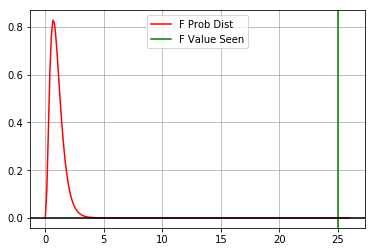

In [203]:
x = np.linspace(0.01, 26, 201)
y = stats.f.pdf(x, dfn, dfd)
_ = plt.plot(x, y, 'r-', label='F Prob Dist')
_ = plt.axvline(F2, color='green', label='F Value Seen')
_ = plt.axhline(0, color='black')
_ = plt.legend(loc='best')
_ = plt.grid()

We use the survival function ```sf``` rather than ```1-cdf()```, as it is supposed to be more accurate.  Note that the value from the equivalent R function gives a different answer, but this to be expected, given the very small value returned.

Clearly, the F value we see is very small, and so we reject H0.

In [186]:
stats.f.sf(res.fvalue, res.df_model, res.df_resid)

1.5355418127893355e-18

-----
## Prediction

To get a prediction of the value of ```lpsa``` for a given set of values of the explanatory variables in our model, we can either form a vector of values (including 1 for the constant or intercept term), and form the dot product with our vector of parameter values (beta).  Alternatively, we can form a dict given the variable values by name, and call the ```predict()``` method of the RegressionResults method

In [187]:
a = [1, 1.3, 3.6, 64, 0.1, 0.2, -0.2, 25]
a_dict = {
    'lcavol': 1.3,
    'lweight': 3.6,
    'age': 64,
    'lbph': 0.1,
    'svi': 0.2,
    'lcp': -0.2,
    'pgg45': 25,
}

Form the dot product

In [188]:
y_hat = sum(res.params.values * a)
y_hat

2.422332304237206

Call the ```predict``` method, as expected, the answers are the same

In [189]:
res.predict(a_dict)

0    2.422332
dtype: float64

We can get the confidence intervals for our prediction by the ```get_prediction``` method.  Note that we can be more confident about the mean of our predictions, than about any one prediction (which must include the error term of our model)

In [190]:
gp = res.get_prediction(a_dict)
gp.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.422332,0.07102,2.281218,2.563447,1.032301,3.812363


------
## Comparing models

Having build and fit our model, we may believe that the true parameter values for ```lcavol``` and ```svi``` are the same.

One way to test this is to use the ```statsmodels``` formula constraint test (obvously not covered in the STATS191 lecture)

In [191]:
to_test = 'lcavol = svi'

t_test = res.t_test(to_test)
print(t_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1829      0.263     -0.694      0.489      -0.706       0.341


We cannot reject the hypothesis the the parameters are the same

A different way to analyse the equivalence of parameters, is to form a different model that has a built in constraint that parameter values for ```lcavol``` and ```svi``` are the same.  We do this by creating a new variable, being the sum of the two variables ```lcavol``` and ```svi```, and including that is our new model


In [192]:
data['z'] = data['lcavol'] + data['svi']
res2 = ols(
    'lpsa ~ z + lweight + age + lbph +  lcp  + pgg45',
    data=data,
).fit()

We now perform a Analysis of Variance on the two models, to see if one has a markedly better explanation of the variance of the dependent variable ```lpsa```.  It appears that the difference we see could arise about 50% of the time, so we are unable to say which model is better. Note we get some spurious diagnostics; however the values match those in the STATS191 lecture


|F	|df.num	|df.den	|p.value|
|--|--|--|--|
|0.4818657	|1	|89	|0.4893864|


In [193]:
anova_lm(res2, res)

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,90.0,43.340952,0.0,NaN,NaN,NaN
1,89.0,43.107558,1.0,0.233394,0.481866,0.489386


----
The final example involved testing if ```lcavol``` and ```svi``` parameters sum to 1.0

The first way to do this is by the ```statsmodels``` formula constraint test.  Again, we find that we cannot get markedly better variance explanation by this constrained model

In [194]:
to_test = 'lcavol + svi = 1'

t_test = res.t_test(to_test)
print(t_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.3219      0.243      1.328      0.188       0.840       1.804


Again at the 5% level, we cannot say which model is better

We can build a new model that enforces our constraint, fit it by OLS, and compare the variance via the F test.  The original model is below

$$\begin{aligned}
Y_i &= \beta_0 + \beta_1 X_{i,{\tt lcavol}}  + \beta_2 X_{i,{\tt lweight}} + \beta_3 X_{i, {\tt age}} \\
& \qquad+ \beta_4 X_{i,{\tt lbph}} + \beta_5 X_{i, {\tt svi}} + \beta_6  X_{i, {\tt lcp}} + \beta_7 X_{i, {\tt pgg45}} + \varepsilon_i
\end{aligned}$$

The new model is as below.  We form new variable ```z2``` and ```y2```

$$\begin{aligned}
Y_i &= \beta_0 + \tilde{\beta}_1 X_{i,{\tt lcavol}}  + \beta_2 X_{i,{\tt lweight}} + \beta_3 X_{i, {\tt age}} \\
& \qquad+ \beta_4 X_{i,{\tt lbph}} + (1 - \tilde{\beta}_1) X_{i, {\tt svi}} + \beta_6  X_{i, {\tt lcp}} + \beta_7 X_{i, {\tt pgg45}} + \varepsilon_i
\end{aligned}$$

In [195]:
data['z2'] = data['lcavol'] - data['svi']
data['y2'] = data['lpsa'] - data['svi']

res3 = ols(
    'y2 ~  z2 + lweight + age + lbph + lcp + pgg45',
    data=data,
).fit()

Perform ANOVA

In [197]:
anova_lm(res3, res)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,90.0,43.961146,0.0,NaN,NaN,NaN
1,89.0,43.107558,1.0,0.853589,1.762322,0.18773


Again, we cannot reject the difference between models are being more than random chance.


---------
## Reproducibility

In [307]:
%watermark -h -iv
%watermark

statsmodels 0.9.0
pandas      1.0.0
seaborn     0.9.0
matplotlib  3.0.2
scipy       1.1.0
numpy       1.15.4
host name: DESKTOP-SODFUN6
2020-03-19T20:15:37+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
